In [114]:
import firedrake
from firedrake import exp, sin, cos, max_value, Constant, interpolate, dx, sqrt, inner, as_vector
from firedrake_adjoint import ReducedFunctional, Control
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import icepack
import icepack.plot
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
    weertman_sliding_law as m
)
import os
import numpy as np
import tqdm
import random
from math import floor
from collections import deque
from scipy.interpolate import RegularGridInterpolator
import pandas as pd

# Grounded ice-stream
We start by defining the domain geometry and the function spaces over which we will be solving the equations of state for ice thickness and ice velocity. We'll use plug flow assumptions (shelfy-stream equations) to bootstrap to solutions that represent vertical shear using the hyrbrid ice-flow model (1st order approximation to the stockes equations). This will solve equations on a 2D footprint mesh that we can then interpolate onto a vertically extruded interval mesh. We'll start by defining the geometry (domain boundaries and basal topogarphy) as well as the perscribed friction coefficient field that we will use in the ice sheet model simulations.


In [2]:
Lx,Ly = 640e3,80e3
ny=25
nx=int(Lx/Ly) * ny
area = Lx*Ly
A = Constant(20)
coarse_mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly)
mesh_hierarchy = firedrake.MeshHierarchy(coarse_mesh, 2)
mesh2d = mesh_hierarchy[1]
Q = firedrake.FunctionSpace(mesh2d, family='CG', degree=2)
V = firedrake.VectorFunctionSpace(mesh2d, family='CG', degree=2)

# Bed topography
We define the base topography using equations for the mismip+ exxperiment that we perturb using a random mid-point displacement algorthim.

In [3]:
def mismip_bed(Q):
    mesh=Q.mesh()
    x, y = firedrake.SpatialCoordinate(mesh)

    x_c = Constant(300e3)
    X = x / x_c

    B_0 = -150
    B_2 = -728.8
    B_4 = 343.91
    B_6 = -50.57
    B_x = B_0 + B_2 * X**2 + B_4 * X**4 + B_6 * X**6

    f_c = 4e3
    d_c = 500
    w_c = 24e3
    B_y = d_c * (
        1 / (1 + exp(-2 * (y - Ly / 2 - w_c) / f_c)) +
        1 / (1 + exp(+2 * (y - Ly / 2 + w_c) / f_c))
    )
    
    z_deep = -720
    z_b = interpolate(max_value(B_x + B_y, z_deep), Q)
    
    return max_value(B_x + B_y, z_deep)

In [4]:
def perturb_bed(Q,V,Nx=nx,Ny=ny,mu=0,sigma=200,method='linear'):
    mesh = Q.mesh()
    element = Q.ufl_element()
    V = firedrake.VectorFunctionSpace(mesh, element)
    X = firedrake.interpolate(mesh.coordinates, V).dat.data_ro
    bed_perturb = firedrake.Function(Q)
    
    size = max(Nx,Ny)
    x=np.linspace(X[:, 0].min(),X[:, 0].max(),size)
    y=np.linspace(X[:, 1].min(),X[:, 1].max(),size)


    perturb=np.zeros((size,size))
    perturb[0][0]=random.randint(0, 0)
    perturb[size-1][0]=random.randint(0, 0)
    perturb[0][size-1]=random.randint(0, 0)
    perturb[size-1][size-1]=random.randint(0, 0)
    
    q = deque()
    q.append((0,0,size-1,size-1,sigma))
    
    while len(q) != 0:
        top, left, bottom, right, randomness = q.popleft()
        centerX = (left + right) // 2
        centerY = (top + bottom) // 2
        
        perturb[centerX][top] = (perturb[left][top] + perturb[right][top]) // 2 + random.randint(-randomness, randomness)
        perturb[centerX][bottom] = (perturb[left][bottom] + perturb[right][bottom]) // 2 + random.randint(-randomness, randomness)
        perturb[left][centerY] = (perturb[left][top] + perturb[left][bottom]) // 2 + random.randint(-randomness, randomness)
        perturb[right][centerY] = (perturb[right][top] + perturb[right][bottom]) // 2 + random.randint(-randomness, randomness)        
        
        perturb[centerX][centerY] = (perturb[left][top] +
                                       perturb[right][top] +
                                       perturb[left][bottom] +
                                       perturb[right][bottom]) // 4 + \
                                      random.randint(-randomness, randomness)

        if right - left > 2:
            q.append((top, left, centerY, centerX, randomness // 2))
            q.append((top, centerX, centerY, right, randomness // 2))
            q.append((centerY, left, bottom, centerX, randomness // 2))
            q.append((centerY, centerX, bottom, right, randomness // 2))

    interpolator = RegularGridInterpolator((x, y), perturb, method=method)
    bed_perturb.dat.data[:] = interpolator(X, method)
    return bed_perturb

In [5]:
def friction_perturb(mesh,n=30,dx=5500,dy=5500):
    
    M=np.random.rand(n,3)
    M[:,0]=(M[:,0])*Lx
    M[:,1]=(M[:,1])*Ly
    M[:,2]=M[:,2]*1e-2
    x,y  = firedrake.SpatialCoordinate(mesh)
    C= Constant(0.0)
    for i in range(n):
        C=C+M[i,2]*exp(-(x-Constant(M[i,0]))**2/dx**2-(y-Constant(M[i,1]))**2/dy**2)
    return C+Constant(5e-3)-x**(1/3)*Constant(5e-3)/Lx**(1/3)
    

In [40]:
if not os.path.exists('../data/initialization/friction.h5'):
    C=interpolate(friction_perturb(mesh2d),Q)
    
    with firedrake.DumbCheckpoint(
        '../data/initialization/friction', mode=firedrake.FILE_CREATE
    ) as checkpoint:
        checkpoint.store(C, name='friction')

else:
    C = firedrake.Function(Q)
    
    with firedrake.DumbCheckpoint(
        '../data/initialization/friction', mode=firedrake.FILE_READ
    ) as checkpoint:
        checkpoint.load(C, name='friction')

In [32]:
z_b = interpolate(mismip_bed(Q), Q)
z_perturb = perturb_bed(Q,Nx=nx,Ny=ny,mu=0,sigma=200,method='linear')

In [43]:
if not os.path.exists('../data/initialization/bed.h5'):
    bed = interpolate(z_perturb+z_b,Q) 
    
    with firedrake.DumbCheckpoint(
        '../data/initialization/bed', mode=firedrake.FILE_CREATE
    ) as checkpoint:
        checkpoint.store(bed, name='bed')

else:
    bed = firedrake.Function(Q)
    
    with firedrake.DumbCheckpoint(
        '../data/initialization/bed', mode=firedrake.FILE_READ
    ) as checkpoint:
        checkpoint.load(bed, name='bed')

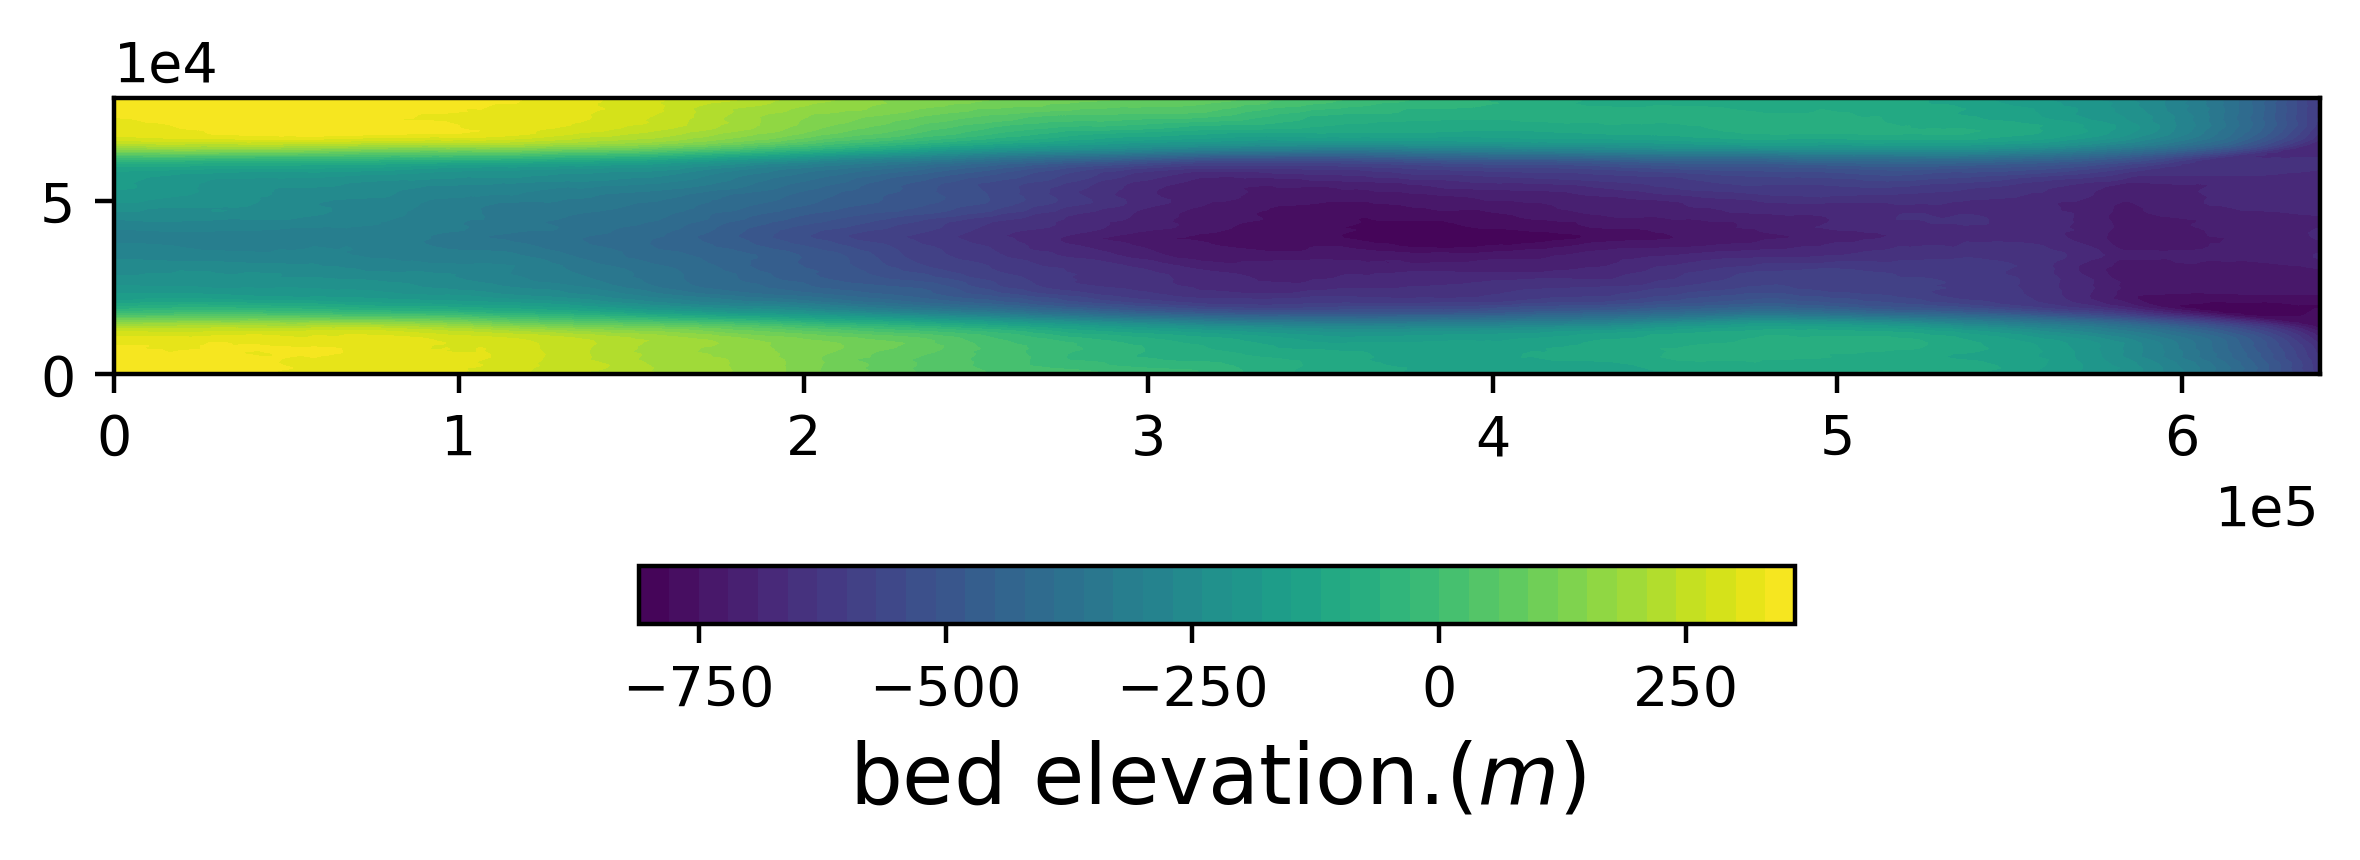

In [44]:
fig, axes = icepack.plot.subplots(dpi=400)
contours = icepack.plot.tricontourf(bed, 40, axes=axes)
CS=plt.colorbar(contours, ax=axes, orientation='horizontal', pad=0.15,fraction=.045,ticks=[-1000,-750,-500,-250,0,250,500])
CS.set_label(r'bed elevation.($m$)',fontsize=15)
plt.tight_layout()
plt.show(fig)
plt.savefig('../figures/fig01/bed.png')
plt.close()

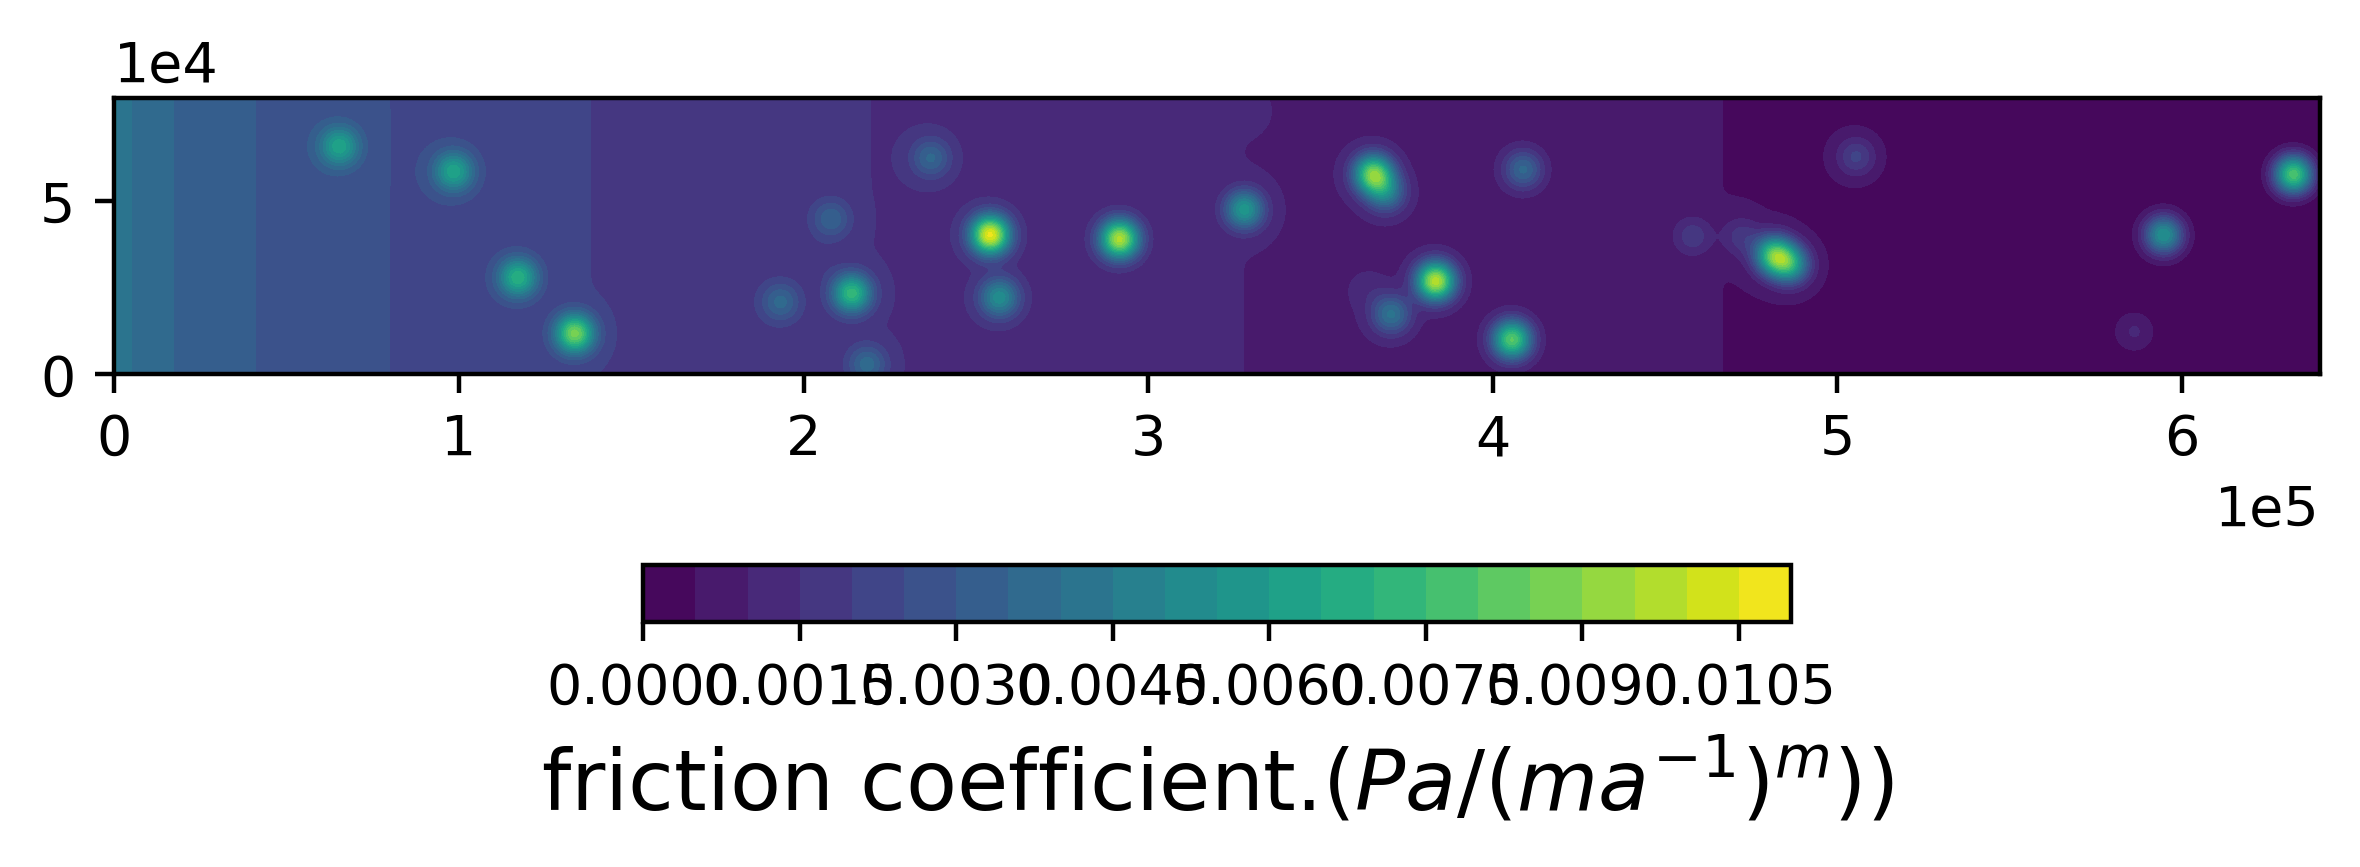

<Figure size 432x288 with 0 Axes>

In [45]:
fig, axes = icepack.plot.subplots(dpi=400)
contours = icepack.plot.tricontourf(C, 25, axes=axes)
CS=plt.colorbar(contours, ax=axes, orientation='horizontal', pad=0.15,fraction=.045)
CS.set_label(r'friction coefficient.($Pa/(ma^{-1})^{m})$)',fontsize=15)
plt.tight_layout()
plt.show(fig)
plt.savefig('../figures/fig01/friction.png')

In [46]:
def friction(**kwargs):
    variables = ('velocity', 'thickness', 'surface', 'friction')
    u, h, s, C = map(kwargs.get, variables)

    p_W = ρ_W * g * max_value(0, -(s - h))
    p_I = ρ_I * g * h
    N = max_value(0, p_I - p_W)
    τ_c = N / 2

    u_c = (τ_c / C)**m
    u_b = sqrt(inner(u, u))

    return τ_c * (
        (u_c**(1/m + 1) + u_b**(1/m + 1))**(m / (m + 1)) - u_c
    )

def flotationHeight(zb, Q, rho_I= ρ_I, rho_W=ρ_W):
    """Given bed elevation, determine height of flotation for function space Q.
    Parameters
    ----------
    zb  : firedrake interp function
        bed elevation (m)
    Q : firedrake function space
        function space
    rho_I : [type], optional
        [description], by default rhoI
    rho_W : [type], optional
        [description], by default rhoW
    Returns
    -------
    zF firedrake interp function
        Flotation height (m)
    """
    # computation for height above flotation
    zF = firedrake.interpolate(firedrake.max_value(-zb * (rho_W/rho_I-1), 0), Q)
    return zF

def flotationMask(s, zF, Q, rho_I=ρ_I, rho_W=ρ_W):
    """Using flotation height, create masks for floating and grounded ice.
    Parameters
    ----------
    zF firedrake interp function
        Flotation height (m)
    Q : firedrake function space
        function space
    rho_I : [type], optional
        [description], by default rhoI
    rho_W : [type], optional
        [description], by default rhoW
    Returns
    -------
    floating firedrake interp function
         ice shelf mask 1 floating, 0 grounded
    grounded firedrake interp function
        Grounded mask 1 grounded, 0 floating
    """
    # smooth to avoid isolated points dipping below flotation.
    zAbove = firedrakeSmooth(icepack.interpolate(s - zF, Q), α=100)
    floating = icepack.interpolate(zAbove < 0, Q)
    grounded = icepack.interpolate(zAbove > 0, Q)
    return floating, grounded

In [55]:
smb = Constant(0.5)
a=firedrake.interpolate(smb,Q)
area = firedrake.assemble(Constant(1) * dx(mesh2d))

In [56]:
model = icepack.models.IceStream(friction=friction)

In [57]:
h_0 = icepack.interpolate(Constant(100), Q)
s_0 = icepack.compute_surface(thickness=h_0, bed=bed)

In [58]:
def normalized_melt(total_melt,floating):
    intMelt = firedrake.assemble(floating * firedrake.dx)
    scale = firedrake.Constant(-1.0 * total_melt/float(intMelt))
    melt = icepack.interpolate(scale * floating, Q)
    return melt


In [59]:
def run_spin_up(solver,C, bed, h, s, u, final_time, dt,total_melt,smb):
    
    zF = flotationHeight(bed, Q)
    num_steps = int(final_time / dt)
    progress_bar = tqdm.trange(num_steps)
    for step in progress_bar:
        
        floating,grounded = flotationMask(s, zF, Q)
        melt = normalized_melt(total_melt,floating)
        a.interpolate(melt+smb)
        h = solver.prognostic_solve(
            dt,
            thickness=h,
            velocity=u,
            accumulation=a,
            thickness_inflow=h_0
        )

        s = icepack.compute_surface(thickness=h, bed=bed)

        u = solver.diagnostic_solve(
            velocity=u,
            thickness=h,
            surface=s,
            fluidity=A,
            friction=C
        )

        min_h = h.dat.data_ro.min()
        avg_h = firedrake.assemble(h * dx) / area
        description = f"avg, min h: {avg_h:4.2f}, {min_h:4.2f}"
        progress_bar.set_description(description)
        
    return h, s, u

In [60]:
def run_melt_variability_obs(solver, C, bed, h, s, u, final_time, dt, total_melt, smb):
    zF = flotationHeight(bed, Q)
    num_steps = int(final_time / dt)
    progress_bar = tqdm.trange(num_steps)
    i=0
    for step in progress_bar:
        floating,grounded = flotationMask(s, zF, Q)
        melt = normalized_melt(total_melt[i],floating)
        a.interpolate(melt+smb)
        h = solver.prognostic_solve(
            dt,
            thickness=h,
            velocity=u,
            accumulation=a,
            thickness_inflow=h_0
        )

        s = icepack.compute_surface(thickness=h, bed=bed)

        u = solver.diagnostic_solve(
            velocity=u,
            thickness=h,
            surface=s,
            fluidity=A,
            friction=C
        )

        min_h = h.dat.data_ro.min()
        avg_h = firedrake.assemble(h * dx) / area
        description = f"avg, min h: {avg_h:4.2f}, {min_h:4.2f}"
        progress_bar.set_description(description)
        i+=1
        
    return h, s, u

In [73]:
def run_melt_variability(solver, C, bed, h, s, u, final_time, dt, melt, smb):
    zF = flotationHeight(bed, Q)
    num_steps = int(final_time / dt)
    progress_bar = tqdm.trange(num_steps)
    for step in progress_bar:
        floating,grounded = flotationMask(s, zF, Q)
        a.interpolate(melt*floating+smb)
        h = solver.prognostic_solve(
            dt,
            thickness=h,
            velocity=u,
            accumulation=a,
            thickness_inflow=h_0
        )

        s = icepack.compute_surface(thickness=h, bed=bed)

        u = solver.diagnostic_solve(
            velocity=u,
            thickness=h,
            surface=s,
            fluidity=A,
            friction=C
        )

        min_h = h.dat.data_ro.min()
        avg_h = firedrake.assemble(h * dx) / area
        description = f"avg, min h: {avg_h:4.2f}, {min_h:4.2f}"
        progress_bar.set_description(description)
        
    return h, s, u

In [62]:
def generate_surface(s,b,sigma):
    X=firedrake.interpolate(mesh2d.coordinates, V).dat.data_ro
    error = np.random.normal(0,sigma, size=s.dat.data.shape)
    s_obs = s.copy(deepcopy=True)
    s_obs.dat.data[:]=error+s.dat.data[:]
    s_obs.dat.data[s_obs.dat.data<b.dat.data]=s.dat.data[s_obs.dat.data<b.dat.data]
    
    return s_obs 
    
def generate_velocity(u,sigma):

    X=firedrake.interpolate(mesh2d.coordinates, V).dat.data_ro
    error = np.random.normal(0,sigma, size=u.dat.data.shape)
    u_obs = u.copy(deepcopy=True)
    u_obs.dat.data[:]=error+u.dat.data[:]
    
    return u_obs

In [63]:
def firedrakeSmooth(q0, α=2e3):
    """[summary]
    Parameters
    ----------
    q0 : firedrake function
        firedrake function to be smooth
    α : float, optional
        parameter that controls the amount of smoothing, which is
        approximately the smoothing lengthscale in m, by default 2e3
    Returns
    -------
    q firedrake interp function
        smoothed result
    """
    q = q0.copy(deepcopy=True)
    J = 0.5 * ((q - q0)**2 + α**2 * firedrake.inner(firedrake.grad(q), firedrake.grad(q))) * firedrake.dx
    F = firedrake.derivative(J, q)
    firedrake.solve(F == 0, q)
    return q

In [64]:
from firedrake import as_vector
opts = {
    'dirichlet_ids': [1],
    'side_wall_ids': [3, 4],
    'diagnostic_solver_type': 'petsc',
    'diagnostic_solver_parameters': {
        'snes_type': 'newtontr',
        'ksp_type': 'preonly',
        'pc_type': 'lu',
        'pc_factor_mat_solver_type': 'mumps'
    }
}
solver = icepack.solvers.FlowSolver(model, **opts)

x,y= firedrake.SpatialCoordinate(mesh2d)
u_0 = solver.diagnostic_solve(
    velocity=interpolate(as_vector((90 * x / Lx, 0)), V),
    thickness=h_0,
    surface=s_0,
    fluidity=A,
    friction=C
)


# Run simulation
We start by defining a user function that can update the thickness surface height and the velocity for several iterations of the prognostic model and return the thickness surface height and velocity of the ice sheet after a chosen length of time.

In [65]:
import os
final_time = 2000
dt = 1

if not os.path.exists('results/mismip-degree1.h5'):
    h, s, u = run_spin_up(
        solver, C, bed, h_0, s_0, u_0, final_time, dt, 0.0, smb
    )
    
    with firedrake.DumbCheckpoint(
        'results/mismip-degree1', mode=firedrake.FILE_CREATE
    ) as checkpoint:
        checkpoint.store(h, name='thickness')
        checkpoint.store(s, name='surface')
        checkpoint.store(u, name='velocity')

else:
    h = firedrake.Function(Q)
    s = firedrake.Function(Q)
    u = firedrake.Function(V)
    
    with firedrake.DumbCheckpoint(
        'results/mismip-degree1', mode=firedrake.FILE_READ
    ) as checkpoint:
        checkpoint.load(h, name='thickness')
        checkpoint.load(s, name='surface')
        checkpoint.load(u, name='velocity')

In [66]:
import os
final_time = 500
dt = 1/3

if not os.path.exists('results/mismip-degree1-melt.h5'):
    h, s, u = run_spin_up(
        solver, C, bed, h, s, u, final_time, dt, 10e9, smb
    )
    
    with firedrake.DumbCheckpoint(
        'results/mismip-degree1-melt', mode=firedrake.FILE_CREATE
    ) as checkpoint:
        checkpoint.store(h, name='thickness')
        checkpoint.store(s, name='surface')
        checkpoint.store(u, name='velocity')

else:
    h = firedrake.Function(Q)
    s = firedrake.Function(Q)
    u = firedrake.Function(V)
    
    with firedrake.DumbCheckpoint(
        'results/mismip-degree1-melt', mode=firedrake.FILE_READ
    ) as checkpoint:
        checkpoint.load(h, name='thickness')
        checkpoint.load(s, name='surface')
        checkpoint.load(u, name='velocity')

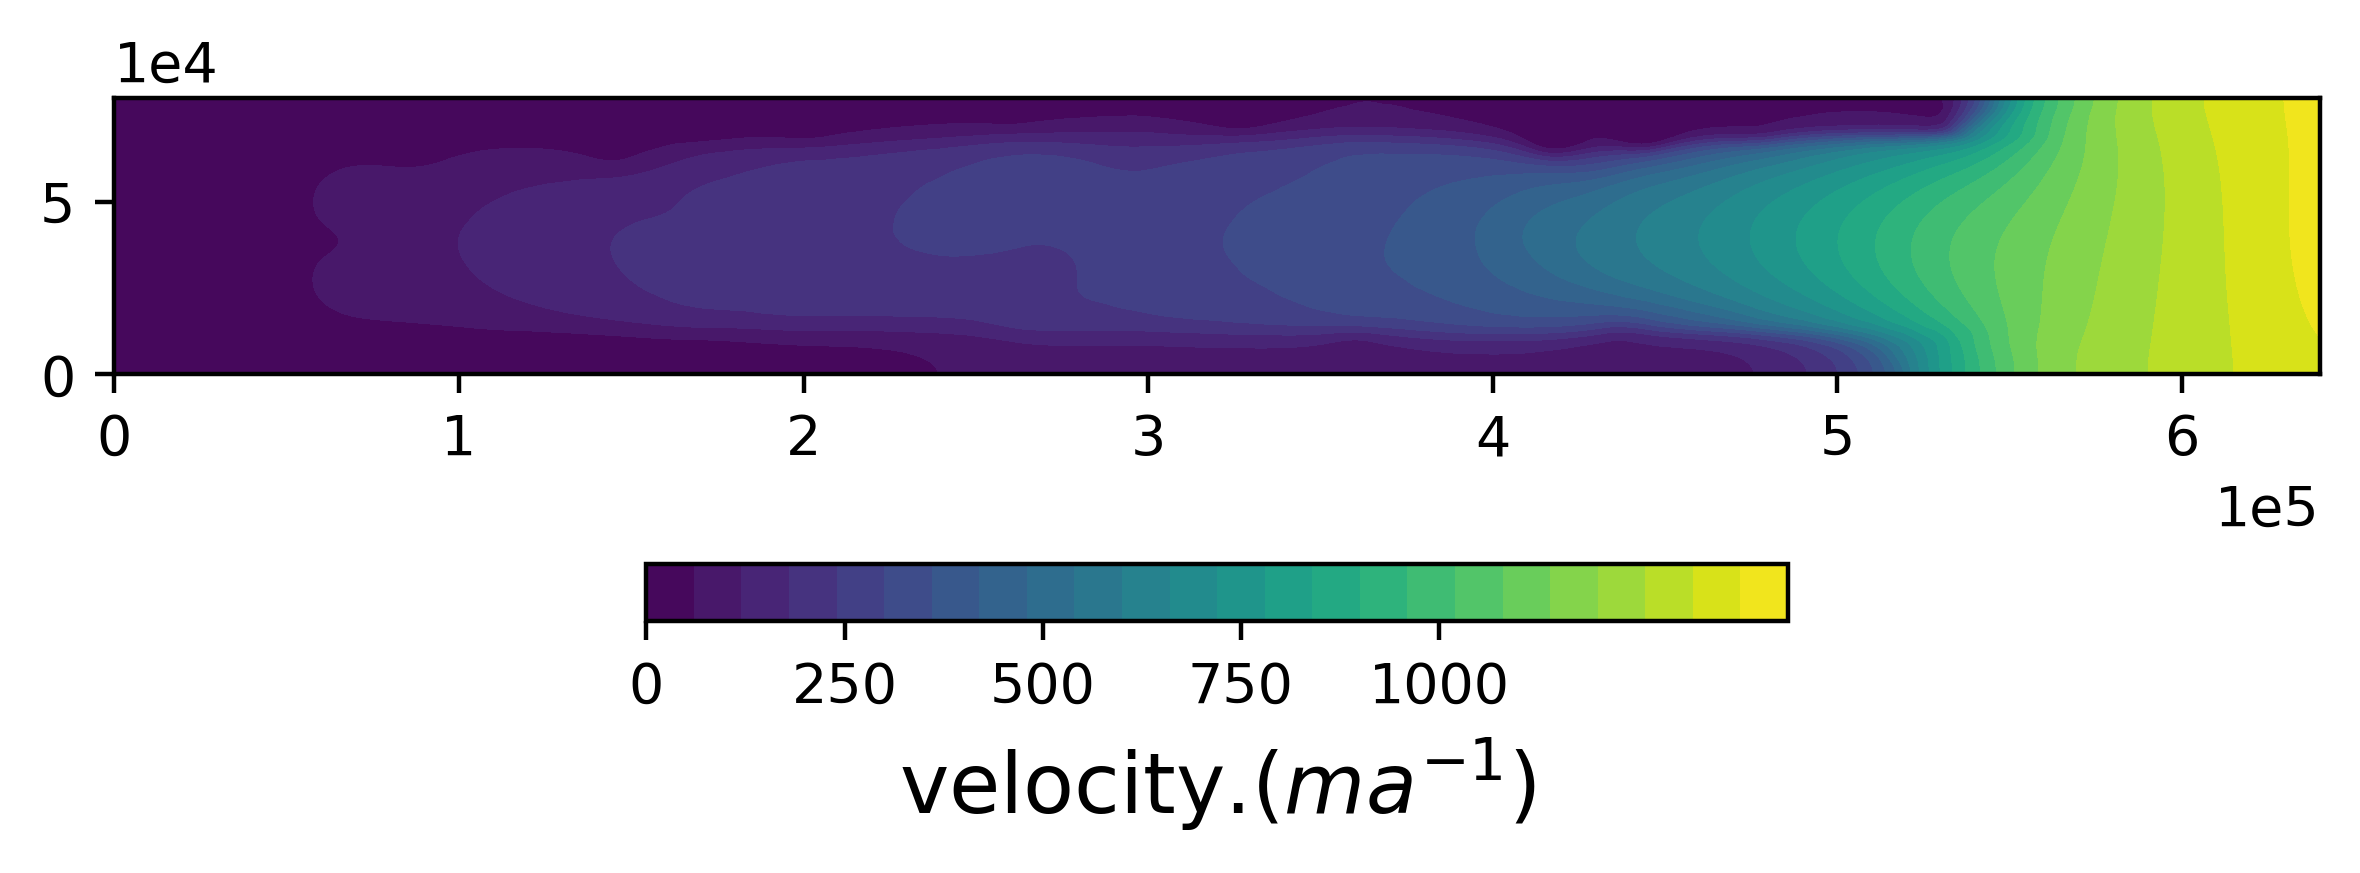

<Figure size 432x288 with 0 Axes>

In [89]:
fig, axes = icepack.plot.subplots(dpi=400)
contours = icepack.plot.tricontourf(u, 25, axes=axes)
CS=plt.colorbar(contours, ax=axes, orientation='horizontal', pad=0.15,fraction=.045,ticks=[0,250,500,750,1000])
CS.set_label(r'velocity.($ma^{-1}$)',fontsize=15)
plt.tight_layout()
plt.show(fig)
plt.savefig('../figures/fig01/velocity.png')

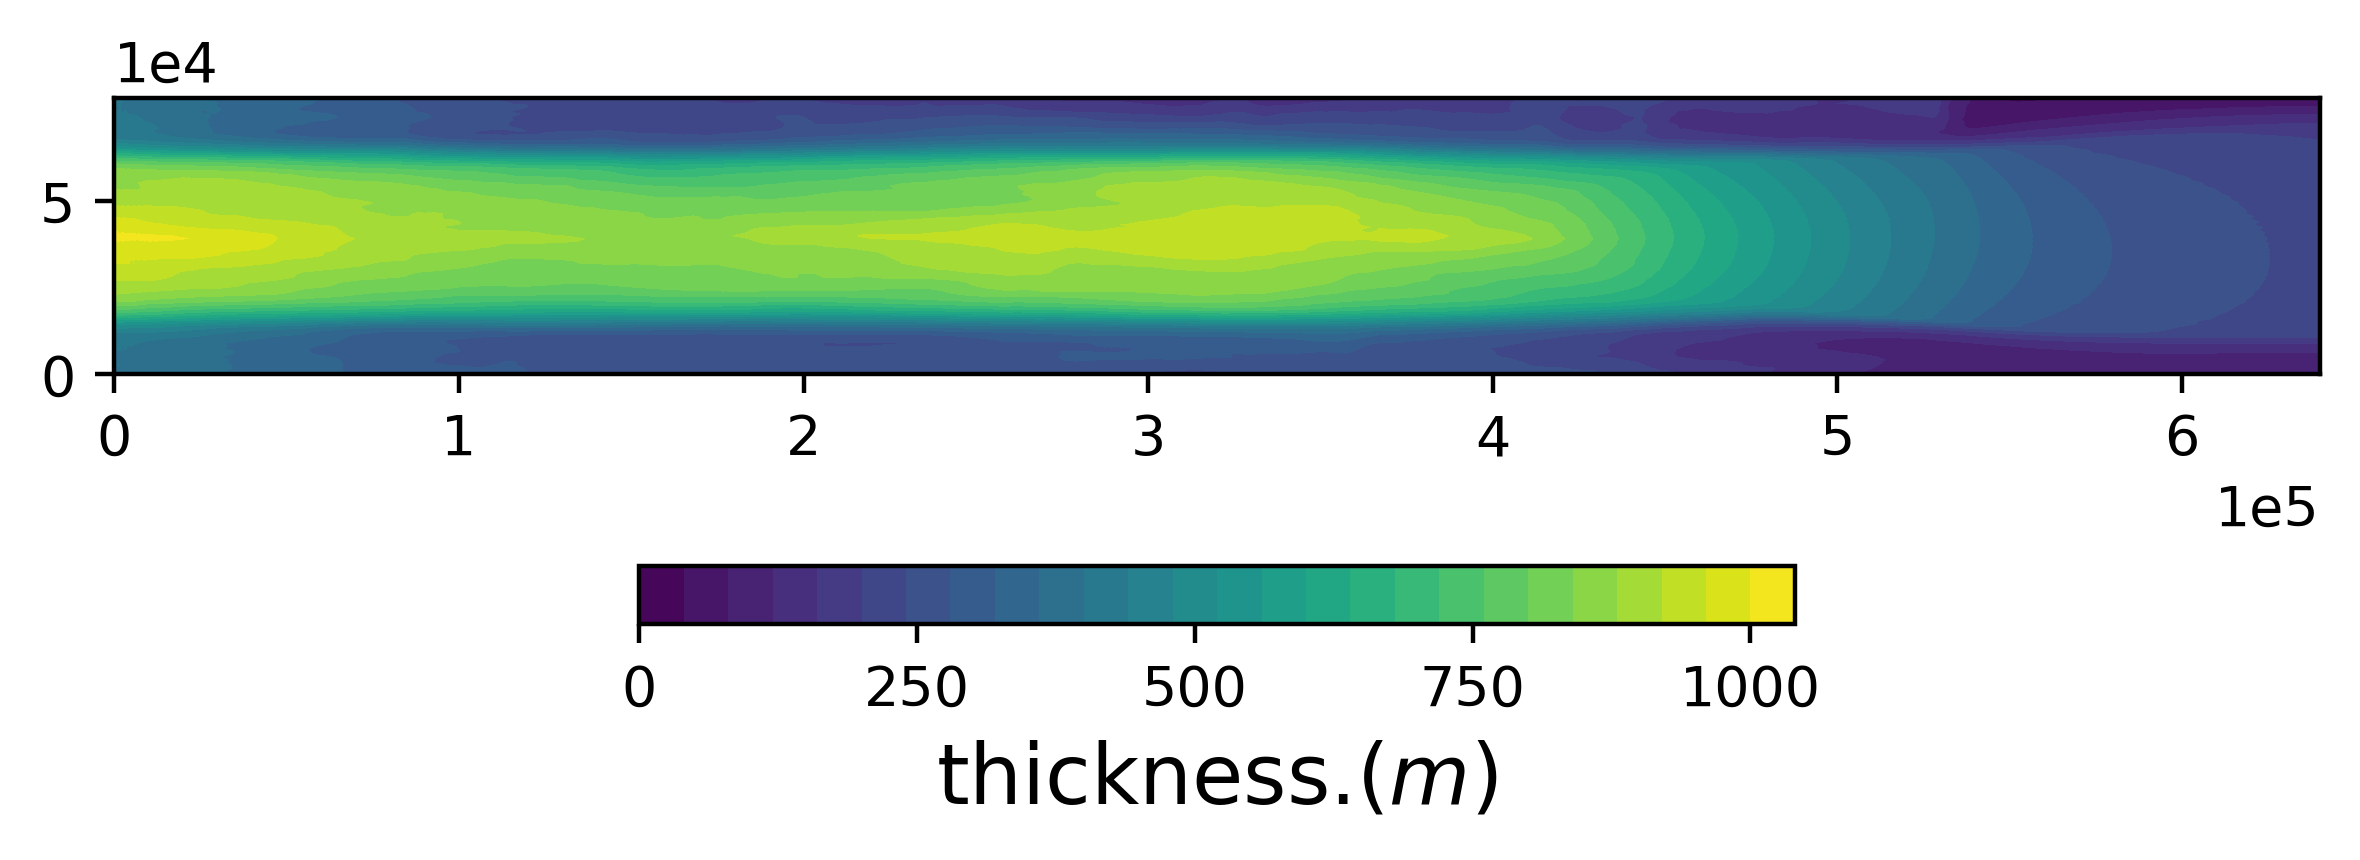

<Figure size 432x288 with 0 Axes>

In [90]:
fig, axes = icepack.plot.subplots(dpi=400)
contours = icepack.plot.tricontourf(h, 25, axes=axes)
CS=plt.colorbar(contours, ax=axes, orientation='horizontal', pad=0.15,fraction=.045,ticks=[0,250,500,750,1000])
CS.set_label(r'thickness.($m$)',fontsize=15)
plt.tight_layout()
plt.show(fig)
plt.savefig('../figures/fig01/thickness.png')

In [67]:
import os
time = 50
obs_sample_rate = 1/4
num_steps=int(time*obs_sample_rate)
dt=1/24
fraction=.2


if not os.path.exists('../data/forcing/melt_variability_{:.3f}.csv'.format(fraction)):
    N=time/dt
    df = 1/(dt*N);
    f0 = 0.5/dt;
    f1 = np.arange(0,f0+df,df)
    # persistence parameters
    beta = 0.5 # exponent for power law noise (slope of spectrum in log-log space)
    r = 0.95 # lag-1 autocorrelation for AR1 noise
    tau = dt/(1-r) # "memory" of AR1 process
    p0 = 1
    
    
    #power spectra (analytical)
    pb = np.sqrt(p0*(f0/f1[1:])**beta)
    pr = np.sqrt(p0/(1 + r**2 - 2*r*np.cos(2*np.pi*dt*f1[1:])))

    #random phases - must be conjugate symmetric
    phase = np.zeros(int(N),dtype = 'complex_')
    pos_freq = pb[1:int(np.ceil(N/2))]; #does NOT include nyquist or DC

    ranphase=np.random.rand(pos_freq.shape[0]); #note this is uniformly, not gaussian distributed from 0 to 1
    phase_half=1j*2*np.pi*ranphase
    phase[1:len(pos_freq)+1]=phase_half
    phase[int(N)-len(pos_freq):] = np.conj(np.flip(phase_half))
    pb2=np.hstack((pb,np.flip(pb[:int(np.floor(N/2))])))
    pr2=np.hstack((pr,np.flip(pb[:int(np.floor(N/2))])))
    anomaly_std=float(10.0*fraction)
    # combine phase and power spectra:
    pbrand = pb2*np.exp(phase);
    prrand = pr2*np.exp(phase);
    pwhite = np.exp(phase);
    
    white = np.fft.ifft(pwhite);
    white = white - np.mean(white);
    white = np.real(white/np.std(white)*anomaly_std);
    
    pl = np.fft.ifft(pbrand);
    pl = pl-np.mean(pl);
    pl = np.real(pl/np.std(pl)*anomaly_std);
    
    ar1 = np.fft.ifft(prrand);
    ar1 = ar1-np.mean(ar1);
    ar1 = np.real(ar1/np.std(ar1)*anomaly_std);
    d = {'time': np.arange(0,N*dt,dt), 'white': white,'ar1':ar1,'pl':pl }
    melt_data=pd.DataFrame(data=d)
    melt_data.to_csv('../data/forcing/melt_variability_{:.3f}.csv'.format(fraction))
else:
    melt_data=pd.read_csv('../data/forcing/melt_variability_{:.3f}.csv'.format(fraction))

In [68]:
melt_data['ar1'][0:6].values

array([ 1.2822449 , -0.30408141, -1.75688561, -1.29417822, -1.94781632,
        0.31903642])

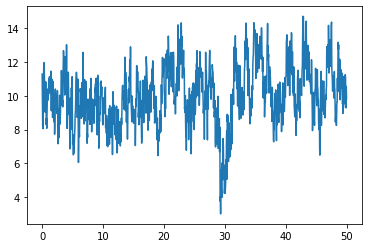

In [72]:
plt.subplots()
plt.plot(melt_data['time'],melt_data['ar1']+10)

In [70]:
time = 50
obs_sample_rate = 1/4
num_steps=int(time/obs_sample_rate)

for i in range(num_steps):
    total_melt=(10+melt_data['ar1'][i*int(obs_sample_rate/dt):(1+i)*int(obs_sample_rate/dt)].values)*1e9
    h,s,u=run_melt_variability_obs(
        solver, C, bed, h, s, u, obs_sample_rate, dt, total_melt, smb
    )
    s_obs=generate_surface(s,bed,2.0)
    u_obs=generate_velocity(u,10.0)
    with firedrake.DumbCheckpoint(
        "../data/observations/modified-mismip_{:03d}".format(i), mode=firedrake.FILE_CREATE
                ) as checkpoint:
                checkpoint.store(s_obs, name='surface')
                checkpoint.store(u_obs, name='velocity')
                

  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.12822449e+10 9.69591859e+09 8.24311439e+09 8.70582178e+09
 8.05218368e+09 1.03190364e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.16037777e+10 1.19021902e+10 1.19624513e+10 1.09690268e+10
 1.01111930e+10 9.76091500e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.03304203e+09 9.77544448e+09 1.08228436e+10 1.00618476e+10
 8.30133630e+09 8.67729403e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.07524129e+09 8.78899092e+09 9.34003178e+09 1.03879820e+10
 9.72912314e+09 1.03749066e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.00728659e+10 1.00416734e+10 1.09313544e+10 1.10262592e+10
 1.04523945e+10 1.11333227e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.01990744e+10 1.11165655e+10 1.01495225e+10 1.04666169e+10
 1.14579008e+10 1.11207471e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.11372049e+09 1.04254453e+10 9.91366932e+09 1.09700987e+10
 1.00934540e+10 8.72080167e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.40500068e+09 1.08526090e+10 1.02901379e+10 9.45728382e+09
 9.45646036e+09 8.45704354e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.84080220e+09 7.73055818e+09 8.51979770e+09 9.91606226e+09
 1.03994460e+10 9.23142484e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.00725141e+10 9.72528689e+09 9.95435224e+09 9.58234591e+09
 8.94975734e+09 1.00164827e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.03044918e+10 1.00483018e+10 9.05157325e+09 7.16635156e+09
 8.99776283e+09 9.20143934e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[7.51913952e+09 8.59014427e+09 8.89616008e+09 1.00327400e+10
 8.32123163e+09 8.90396635e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.85815987e+09 1.00024768e+10 9.89316590e+09 1.13586884e+10
 1.14908011e+10 1.12087571e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.08905902e+10 9.42114039e+09 9.73328197e+09 9.33986183e+09
 1.02334473e+10 1.18988486e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.26646370e+10 1.23125682e+10 1.15511309e+10 1.22939686e+10
 1.11136560e+10 1.00441319e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.13271179e+10 1.07570218e+10 1.23106246e+10 1.11298583e+10
 1.14003646e+10 1.09532793e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.30139087e+10 1.03473788e+10 8.07344398e+09 8.86094075e+09
 1.05258542e+10 1.00673902e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.89881457e+09 1.13957981e+10 1.02503072e+10 9.58988406e+09
 9.43187651e+09 9.01200940e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.47819470e+09 6.86231054e+09 7.71758351e+09 9.86974071e+09
 7.97676103e+09 9.20274949e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.19269668e+09 1.04663829e+10 9.76439809e+09 9.78153900e+09
 1.11272774e+10 8.86309139e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[7.15293762e+09 7.60277461e+09 7.70160710e+09 6.50982079e+09
 7.45412492e+09 6.61260604e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[6.86125010e+09 7.29304138e+09 7.76068127e+09 8.13562282e+09
 8.93146830e+09 9.01343809e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.71927800e+09 1.09264419e+10 1.12547576e+10 1.13879367e+10
 1.12432212e+10 1.02632599e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.72041814e+09 8.81906694e+09 9.20233843e+09 1.09855299e+10
 8.51561659e+09 6.06056385e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[7.68057304e+09 8.73972257e+09 7.77451581e+09 7.58376788e+09
 9.39223692e+09 8.89211109e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.04237483e+10 1.02184206e+10 1.02967769e+10 1.03984316e+10
 8.67102994e+09 8.79082140e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.95173586e+09 1.07809168e+10 1.06332543e+10 8.77202159e+09
 1.00555009e+10 1.25652415e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.04495444e+10 8.87617332e+09 8.46361525e+09 8.33268115e+09
 9.70243167e+09 1.09578755e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.04500410e+10 8.50771927e+09 9.08643482e+09 1.00394103e+10
 1.08533660e+10 9.94666345e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.50887004e+09 9.72484983e+09 9.40864627e+09 7.19451318e+09
 7.76815028e+09 7.53895544e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.80654599e+09 8.72173703e+09 8.59142957e+09 8.83361801e+09
 9.29881084e+09 9.30079830e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.40523707e+09 9.03247240e+09 8.31161338e+09 1.04147307e+10
 9.47020505e+09 1.03406147e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.10286297e+10 8.31500545e+09 9.52789639e+09 7.86846452e+09
 8.73134286e+09 8.94630771e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.80783159e+09 9.71833299e+09 8.64408609e+09 9.42274388e+09
 8.82966232e+09 8.71165460e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.37570093e+09 9.03035099e+09 9.78513779e+09 9.40387577e+09
 1.04613586e+10 1.02220974e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.07062141e+10 1.04425387e+10 1.09034715e+10 1.10438176e+10
 9.19115422e+09 8.09258811e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[7.95893999e+09 7.68957679e+09 7.93255977e+09 1.12148071e+10
 9.77914802e+09 9.25440296e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.98821257e+09 6.90184192e+09 8.02968419e+09 8.68867252e+09
 8.48600346e+09 8.98529946e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.90570217e+09 9.25498898e+09 1.07995116e+10 1.03798283e+10
 1.08752500e+10 1.00646230e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.04360949e+10 1.05246688e+10 9.90104586e+09 9.69518444e+09
 8.42311684e+09 8.28227488e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.74268802e+09 9.87071397e+09 9.36889328e+09 8.97201492e+09
 9.83546255e+09 8.94540758e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.95805015e+09 1.00151317e+10 1.01713404e+10 1.05058518e+10
 8.12685339e+09 8.59792379e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.31861444e+09 7.78521755e+09 8.83615478e+09 7.85966580e+09
 7.06324176e+09 7.79644532e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[6.99317220e+09 7.12038527e+09 8.25331527e+09 8.62149461e+09
 8.30798787e+09 8.08877490e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.23813332e+09 7.14272629e+09 9.41952538e+09 8.52975684e+09
 8.29571936e+09 8.97322937e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[7.54867315e+09 8.80053959e+09 7.94831533e+09 8.59817685e+09
 9.24575427e+09 9.32652270e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[7.70604407e+09 6.52878268e+09 8.43514791e+09 1.02407561e+10
 9.83413467e+09 9.21045517e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.34048131e+09 9.43870338e+09 8.56533503e+09 9.33752262e+09
 7.83064215e+09 7.69050117e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[7.74201655e+09 7.71712036e+09 8.13596556e+09 7.42366650e+09
 8.54613456e+09 9.39340032e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.52800292e+09 6.62183142e+09 6.72051608e+09 8.39462232e+09
 7.68899987e+09 7.87840847e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.18665599e+09 7.19851781e+09 7.26851001e+09 8.46956097e+09
 7.74140570e+09 7.77288524e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.45166771e+09 7.49810335e+09 7.03993129e+09 7.74550479e+09
 7.28235154e+09 7.65288599e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.68571630e+09 8.29351610e+09 8.88554795e+09 1.00048211e+10
 1.04487498e+10 1.06170990e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.82478050e+09 1.02699112e+10 1.00614207e+10 1.02845719e+10
 9.37066362e+09 9.19495413e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.02953377e+10 1.12275021e+10 1.22821793e+10 1.11992655e+10
 9.12040225e+09 1.13849749e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.06547842e+10 9.66119540e+09 8.43788639e+09 9.38756063e+09
 8.53352218e+09 8.13998328e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[7.44063309e+09 8.15457605e+09 9.75071628e+09 1.01488559e+10
 1.03965662e+10 9.58007409e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.88851358e+09 1.11232640e+10 1.08376534e+10 1.21330365e+10
 1.15289837e+10 1.08460219e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.28913166e+10 1.03434722e+10 9.68192724e+09 9.38842070e+09
 8.98084594e+09 8.46824082e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.98859812e+09 8.99319584e+09 9.40307661e+09 9.40174541e+09
 8.56005297e+09 8.42085677e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.37220639e+09 8.38592919e+09 9.19935560e+09 9.09960465e+09
 9.09727116e+09 8.92900647e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.71120499e+09 7.05623931e+09 8.04202264e+09 9.83159875e+09
 9.39404310e+09 9.87049556e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.17784862e+10 1.17752589e+10 1.11577118e+10 1.02309544e+10
 1.14251041e+10 1.05525344e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.01794357e+10 8.72690226e+09 9.01753751e+09 8.29042194e+09
 8.83688159e+09 1.00413933e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.01861848e+10 8.73858127e+09 1.00197750e+10 1.08739243e+10
 9.25694589e+09 9.72569450e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.90255153e+09 8.29255310e+09 7.20232074e+09 7.59945322e+09
 9.29353988e+09 8.88307762e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.68898956e+09 1.09251831e+10 1.05384042e+10 9.74477129e+09
 8.41027578e+09 9.54444406e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.95192972e+09 1.02579914e+10 9.74943265e+09 1.11527965e+10
 1.02011832e+10 1.06157898e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.02171651e+10 8.97517278e+09 1.23039140e+10 1.18971683e+10
 1.16730547e+10 1.10221573e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.07927983e+10 9.88103478e+09 9.07310690e+09 7.96503196e+09
 8.79931396e+09 9.51787577e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.64859698e+09 1.03382301e+10 8.53398055e+09 9.16769811e+09
 9.73691930e+09 1.06446829e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.03310798e+10 1.03021326e+10 9.03626239e+09 1.07742625e+10
 1.07967665e+10 1.08218978e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.04002638e+10 1.15873559e+10 1.03506705e+10 1.18385130e+10
 1.20638817e+10 1.18563814e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.03117899e+10 1.03784667e+10 9.26625048e+09 1.05677063e+10
 1.06015843e+10 8.38877707e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.72509633e+09 8.46820860e+09 9.16430160e+09 9.70436388e+09
 9.96486925e+09 9.25036511e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.32355821e+09 8.25419249e+09 8.34759580e+09 7.39568004e+09
 8.68111841e+09 7.41173429e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[6.46148809e+09 7.63950709e+09 7.75633560e+09 7.97347538e+09
 7.31641321e+09 7.87669308e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[7.88098443e+09 7.78247003e+09 9.11698218e+09 8.45757769e+09
 8.92931890e+09 7.87536191e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.62994824e+09 1.06519220e+10 1.06178085e+10 9.53946411e+09
 1.09860900e+10 1.12885415e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.22663922e+10 1.13399385e+10 1.11323917e+10 1.11930877e+10
 1.14660528e+10 1.21983579e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.09387054e+10 1.02157993e+10 1.00017658e+10 9.07202411e+09
 8.76649254e+09 9.68592323e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.23874510e+09 9.81199029e+09 1.24662991e+10 1.18413715e+10
 1.18741567e+10 1.14310065e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.10430788e+10 1.26951603e+10 1.14483565e+10 1.16487799e+10
 1.21386842e+10 1.35270668e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.29513188e+10 1.12790476e+10 1.00906132e+10 1.11215074e+10
 1.09562236e+10 1.09600940e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.23168584e+10 1.21457040e+10 1.25378589e+10 1.19693092e+10
 1.14331663e+10 1.05347055e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.20248550e+10 1.22520163e+10 1.25574373e+10 1.07906514e+10
 1.06562893e+10 1.09742662e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.02341152e+10 1.25742888e+10 1.20927647e+10 1.05863777e+10
 9.50966719e+09 9.72597415e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.76821560e+09 9.83803977e+09 9.93884816e+09 8.92993668e+09
 9.84063581e+09 1.05318563e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.06978790e+10 1.06505913e+10 1.09638507e+10 1.16830479e+10
 9.99022087e+09 1.09653383e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.23158097e+10 1.41879452e+10 1.18852442e+10 1.09388479e+10
 1.02989772e+10 1.25856918e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.06949787e+10 1.17748891e+10 1.21423505e+10 1.33577456e+10
 1.32379769e+10 1.20911737e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.18744917e+10 1.34859124e+10 1.43085721e+10 1.32422155e+10
 1.29575165e+10 1.34880358e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.10808391e+10 1.10493294e+10 1.16482960e+10 1.12564850e+10
 1.18402890e+10 1.26881825e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.13220850e+10 1.16324846e+10 1.12624613e+10 9.21919885e+09
 9.53672119e+09 9.01123496e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.00097428e+10 8.40695708e+09 7.59402517e+09 8.69138628e+09
 6.78314791e+09 8.57652410e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.37397411e+09 8.68043823e+09 9.76100710e+09 9.36391724e+09
 9.42446726e+09 8.45193122e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.44301841e+09 7.40540122e+09 8.53582536e+09 9.32653255e+09
 1.04552797e+10 8.37158801e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.95975031e+09 1.00548590e+10 8.94827805e+09 9.55416097e+09
 9.02584558e+09 6.57417538e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.03609020e+09 9.18599600e+09 1.02447089e+10 9.56925267e+09
 1.04652896e+10 1.05668156e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.70676904e+09 1.07503256e+10 8.46524531e+09 1.07346187e+10
 9.89257332e+09 7.99695517e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.72996723e+09 9.80820950e+09 1.03708722e+10 8.89805558e+09
 9.15247780e+09 1.14771713e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.90827787e+09 1.14379584e+10 1.19078922e+10 1.15837922e+10
 1.26660835e+10 1.06276938e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.05229021e+10 1.12099011e+10 9.99284153e+09 1.03915711e+10
 1.04991249e+10 1.06898499e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.16783420e+10 9.43564817e+09 9.98580737e+09 1.26104468e+10
 1.22519170e+10 1.19378106e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.11178230e+10 1.12423530e+10 1.16307599e+10 1.13367463e+10
 1.13148218e+10 1.10667548e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.02110599e+10 1.12813345e+10 1.13916142e+10 1.05620521e+10
 1.00354308e+10 8.97087497e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.20889751e+09 9.08559573e+09 9.42252827e+09 7.42983184e+09
 9.55371852e+09 9.54293971e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.02857387e+10 9.21238763e+09 1.25731339e+10 1.08751320e+10
 1.14010420e+10 1.14357653e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.01617958e+10 9.26562895e+09 9.17772174e+09 7.39523478e+09
 1.06054984e+10 9.21222588e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.00741016e+10 1.01739128e+10 1.08516657e+10 1.07465672e+10
 1.16858173e+10 1.22796729e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.26828678e+10 1.18954881e+10 1.15294965e+10 1.05006001e+10
 1.08685804e+10 9.79773877e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.06736085e+10 1.08564273e+10 1.10714026e+10 1.04937585e+10
 1.18343685e+10 1.16511526e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.14582932e+10 1.13803997e+10 1.08492052e+10 9.28149705e+09
 1.02091820e+10 1.07423929e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.74362556e+09 9.06084288e+09 8.96811826e+09 9.71491873e+09
 7.37301124e+09 6.97697543e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.18231213e+09 8.14986470e+09 7.26940538e+09 8.19463722e+09
 7.75400292e+09 9.28849584e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[7.12711447e+09 8.69451891e+09 9.96906538e+09 7.72962578e+09
 6.88490190e+09 8.52791270e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[7.00458291e+09 7.92155182e+09 8.65491599e+09 6.68485833e+09
 8.14703277e+09 3.77564879e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[4.04814106e+09 3.01981916e+09 5.54056745e+09 5.60958911e+09
 4.51906943e+09 4.30056042e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[3.99054662e+09 6.04016081e+09 5.30876256e+09 5.02860026e+09
 5.27710490e+09 7.47664445e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[6.96935258e+09 5.22106687e+09 5.24020742e+09 5.56458729e+09
 4.23783299e+09 4.61514139e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[5.90640253e+09 4.24551437e+09 4.58409442e+09 4.90665798e+09
 6.21245866e+09 5.51392138e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[7.35230906e+09 7.92419610e+09 5.07289360e+09 8.90359314e+09
 8.46079844e+09 8.86085988e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.17627859e+09 7.33460502e+09 6.11766985e+09 8.42114912e+09
 8.19645931e+09 7.96268566e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[6.83188572e+09 6.38449128e+09 7.50849073e+09 6.42269933e+09
 7.39652218e+09 6.82644039e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.00742896e+10 8.48922402e+09 9.24017158e+09 8.77014386e+09
 7.16189307e+09 9.38745650e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.84779234e+09 1.03586327e+10 1.04033421e+10 1.01404250e+10
 9.49164209e+09 1.17136566e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.28780897e+10 1.21691982e+10 1.08640559e+10 1.23906685e+10
 1.24167528e+10 1.35488063e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.20662795e+10 1.28088140e+10 1.23238849e+10 1.13978548e+10
 1.19955839e+10 1.04177855e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.07704772e+10 1.05640958e+10 9.40348147e+09 1.07713006e+10
 9.93726942e+09 1.18041791e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.31600537e+09 9.43988188e+09 9.24596280e+09 8.59657026e+09
 1.08705207e+10 1.17775622e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.02389815e+10 9.22378824e+09 9.73584838e+09 8.73985226e+09
 8.67557917e+09 9.40640197e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.04796323e+10 1.02479606e+10 1.04954905e+10 8.95916726e+09
 1.01844985e+10 8.86177821e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.02223008e+10 9.63235388e+09 1.02061323e+10 9.17778436e+09
 1.06275499e+10 1.16036306e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.17921638e+10 1.32317732e+10 1.24799424e+10 1.21361478e+10
 1.39088427e+10 1.42970540e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.27968238e+10 1.24627303e+10 1.33901047e+10 1.28813714e+10
 1.23186118e+10 1.14800516e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.28556602e+10 1.00074983e+10 1.14358128e+10 1.07888620e+10
 1.08086508e+10 1.15874281e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.03857115e+10 8.83813066e+09 8.34174818e+09 8.85952937e+09
 9.13624122e+09 9.80826733e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.14808030e+09 8.80883626e+09 9.85832677e+09 9.32738892e+09
 1.05062739e+10 9.27634297e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.06133779e+10 1.03565178e+10 1.19157489e+10 1.22827980e+10
 1.24589403e+10 1.32563881e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.43166198e+10 1.40642453e+10 1.36250590e+10 1.38527430e+10
 1.39041502e+10 1.36137737e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.29970627e+10 1.21552319e+10 1.10271137e+10 1.23818773e+10
 1.36582757e+10 1.23921386e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.36694304e+10 1.35091443e+10 1.13941155e+10 1.20121438e+10
 1.29286852e+10 1.30318513e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.24915116e+10 1.20691955e+10 1.16205927e+10 1.27088599e+10
 1.24682486e+10 1.29685700e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.35157148e+10 1.23867354e+10 1.34452291e+10 1.29634861e+10
 1.26243645e+10 1.21589067e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.40120803e+10 1.31291727e+10 1.21988967e+10 1.23291085e+10
 1.14217773e+10 1.22828592e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.96569869e+09 9.87118055e+09 1.08592296e+10 1.05782665e+10
 1.07807141e+10 1.11361995e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.75301533e+09 9.62074784e+09 1.01400749e+10 9.60924945e+09
 1.05100016e+10 1.11720011e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.03035052e+10 1.04741378e+10 1.01577125e+10 1.06661264e+10
 1.29138068e+10 1.32385825e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.42713223e+10 1.21378261e+10 1.29656966e+10 1.22486670e+10
 1.24636153e+10 1.09179107e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.01655250e+10 1.03717054e+10 1.17225232e+10 1.07667103e+10
 1.14553327e+10 1.11283816e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.05669839e+10 9.68162211e+09 9.34990898e+09 1.00144419e+10
 9.75913379e+09 8.48198868e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.04974764e+10 1.04276060e+10 9.15813259e+09 9.10597185e+09
 8.56764748e+09 7.42996016e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[7.28009277e+09 7.97700056e+09 7.98709363e+09 8.73146944e+09
 9.81085295e+09 9.20671043e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.01447435e+10 9.04555920e+09 1.03466946e+10 8.99980430e+09
 8.01667767e+09 7.34939470e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.58806812e+09 8.28100408e+09 9.83912003e+09 9.87025579e+09
 9.77875919e+09 1.04249080e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.06897435e+10 8.84852523e+09 8.42743888e+09 9.21191745e+09
 9.11548148e+09 8.98804700e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.08048498e+10 1.03358885e+10 1.02545248e+10 9.48473522e+09
 9.12892873e+09 9.49481984e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.95119930e+09 7.88318295e+09 8.69888289e+09 8.45836110e+09
 8.97616513e+09 1.02315273e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.07610728e+10 8.27668998e+09 9.70678714e+09 9.40991158e+09
 9.27393332e+09 9.67086242e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.06564128e+09 9.52851133e+09 1.10691940e+10 1.04871842e+10
 9.90965708e+09 1.05303634e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.11417882e+10 1.11558123e+10 1.31654793e+10 1.33340956e+10
 1.36012829e+10 1.27096552e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.27184140e+10 1.13169260e+10 1.06046850e+10 1.07613993e+10
 1.19035208e+10 1.14611124e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.27860555e+10 1.29044705e+10 1.21038854e+10 1.00226123e+10
 1.23695823e+10 1.32348724e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.13896096e+10 1.18220255e+10 1.28040247e+10 1.31779189e+10
 1.37278231e+10 1.35905336e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.24153484e+10 1.12281095e+10 1.25926950e+10 1.03769714e+10
 1.02178046e+10 1.07982185e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.00190390e+10 1.17061710e+10 1.03820908e+10 9.36029445e+09
 9.11381232e+09 8.75650123e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.76324771e+09 1.01102823e+10 8.77188797e+09 8.79894775e+09
 7.66151497e+09 8.98938901e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.52470927e+09 8.52261798e+09 9.48683190e+09 9.25946669e+09
 1.09936410e+10 1.13448105e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.15100551e+10 1.04189619e+10 9.75646392e+09 9.99552601e+09
 1.02905657e+10 9.07907911e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.68412614e+09 8.69856894e+09 1.09123137e+10 1.10219833e+10
 1.03522240e+10 1.03385893e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.03324062e+10 1.01217739e+10 1.00184730e+10 1.09123670e+10
 1.15687263e+10 1.17360066e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.34264979e+10 1.46992781e+10 1.39445558e+10 1.46717509e+10
 1.33636326e+10 1.13506582e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.05655266e+10 1.24819594e+10 1.22572213e+10 1.15684809e+10
 1.31995480e+10 1.25513623e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.26493732e+10 1.28722614e+10 1.44062353e+10 1.31712337e+10
 1.25517428e+10 1.09250228e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.12375297e+10 1.23317570e+10 1.09654613e+10 1.29781276e+10
 1.19646674e+10 1.10471926e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.26120462e+10 1.25044931e+10 1.19546508e+10 1.08375221e+10
 1.12353476e+10 1.12716122e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.07850502e+10 1.06505857e+10 1.03220012e+10 1.01234851e+10
 1.01310926e+10 1.21273103e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.09293154e+10 1.01261711e+10 9.21585521e+09 7.94118696e+09
 8.60657718e+09 9.01741197e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.51182354e+09 1.02037592e+10 8.83097415e+09 9.08481422e+09
 8.53682116e+09 8.25822663e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.91750264e+09 1.03310848e+10 1.04606297e+10 1.16255475e+10
 1.11330402e+10 1.11868721e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.07778403e+10 9.67657405e+09 9.41022210e+09 1.07180204e+10
 1.15494283e+10 1.05138645e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.04006845e+10 9.76448916e+09 9.77546404e+09 8.38955836e+09
 8.19016825e+09 7.99284255e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.20106925e+09 6.88408052e+09 6.49268493e+09 8.97908168e+09
 9.21689168e+09 1.05316713e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.04062765e+10 1.14450698e+10 8.25624275e+09 9.08833324e+09
 9.85530113e+09 1.08812914e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.88766038e+09 1.07864807e+10 9.67963250e+09 9.09749987e+09
 9.48436944e+09 1.08641656e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[8.90188759e+09 9.10676304e+09 9.67777635e+09 9.11653264e+09
 8.69356217e+09 9.03181693e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.56055481e+09 1.00597052e+10 9.79613604e+09 1.03324411e+10
 1.05928187e+10 1.27466486e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.29061165e+10 1.18620079e+10 1.17047493e+10 1.30244736e+10
 1.19033251e+10 1.25319720e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.41593860e+10 1.31962160e+10 1.13439450e+10 1.26296361e+10
 1.28347317e+10 1.32989150e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.30983308e+10 1.17318677e+10 1.30186602e+10 1.22259611e+10
 1.27985275e+10 1.42051298e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.43539536e+10 1.16664161e+10 1.12292883e+10 1.09952199e+10
 1.02784024e+10 1.04499758e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.10257879e+10 1.11819026e+10 1.03657426e+10 9.87027691e+09
 1.04690197e+10 1.14346419e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.04838994e+10 1.03692590e+10 9.37414378e+09 8.46013303e+09
 8.67696741e+09 8.96019195e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[9.42460031e+09 8.25175519e+09 8.79609493e+09 9.62421485e+09
 9.62657918e+09 1.10385226e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.02719295e+10 1.15150935e+10 1.31577308e+10 1.27504511e+10
 1.30104780e+10 1.05084424e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.11115190e+10 1.02170627e+10 1.21562589e+10 1.19954616e+10
 9.76365803e+09 1.04441817e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.07804366e+10 1.15423062e+10 1.05458590e+10 1.13559855e+10
 1.04706555e+10 1.13323395e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.01489116e+10 9.52482413e+09 9.62992437e+09 8.96118472e+09
 9.53742665e+09 9.31428701e+09]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.11418510e+10 9.51386926e+09 1.10057340e+10 1.05095677e+10
 1.06043062e+10 1.04865659e+10]


  0%|                                                                                      | 0/6 [00:00<?, ?it/s]

[1.12470613e+10 1.10850344e+10 9.94786654e+09 9.28433862e+09
 1.05488383e+10 9.80069940e+09]


avg, min h: 504.16, 21.22: 100%|███████████████████████████████████████████████████| 6/6 [00:43<00:00,  7.25s/it]


In [74]:
time = 10
obs_sample_rate = 1/4
num_steps=int(time/obs_sample_rate)

s_obs_timeseries=[]
u_obs_timeseries=[]

for i in range(num_steps):
    with firedrake.DumbCheckpoint(
        "../data/observations/modified-mismip_{:03d}".format(i), mode=firedrake.FILE_READ
    ) as checkpoint:
        checkpoint.load(s_obs, name='surface')
        checkpoint.load(u_obs, name='velocity')
    
    s_obs_timeseries.append(s_obs)
    u_obs_timeseries.append(u_obs)

In [102]:
from collections import OrderedDict
ctrls = OrderedDict()
u_obs_timeseries = OrderedDict()
s_obs_timeseries = OrderedDict()
t=float(obs_sample_rate)
i=0
R=firedrake.FunctionSpace(mesh2d, family='R', degree=0)
while t<=time:
    with firedrake.DumbCheckpoint(
        "../data/observations/modified-mismip_{:03d}".format(i), mode=firedrake.FILE_READ
    ) as checkpoint:
        checkpoint.load(s_obs, name='surface')
        checkpoint.load(u_obs, name='velocity')
    
    s_obs_timeseries[t]=s_obs
    u_obs_timeseries[t]=u_obs
    ctrls[t] = firedrake.Function(R)
    t+=float(obs_sample_rate)  

In [109]:
def solve_melt(ctrls,time=10):
    h = firedrake.Function(Q)
    s = firedrake.Function(Q)
    u = firedrake.Function(V)
    
    with firedrake.DumbCheckpoint(
        'results/mismip-degree1-melt', mode=firedrake.FILE_READ
    ) as checkpoint:
        checkpoint.load(h, name='thickness')
        checkpoint.load(s, name='surface')
        checkpoint.load(u, name='velocity')
    
    t=float(obs_sample_rate)
    j = .5*float(obs_sample_rate)*firedrake.assemble((u-u_obs_timeseries[t])**2*firedrake.dx) + \
    .5*float(obs_sample_rate)*firedrake.assemble((s-s_obs_timeseries[t])**2*firedrake.dx) 
    while t<=time:
        h,s,u=run_melt_variability(solver, C, bed, h, s, u, obs_sample_rate, dt, ctrls[t], smb
                                  )
        if t > time - float(obs_sample_rate):
            weight = .5
        else:
            weight = 1.
            j+=weight*float(obs_sample_rate)*firedrake.assemble((u-u_obs_timeseries[t])**2*firedrake.dx) + \
            weight*float(obs_sample_rate)*firedrake.assemble((s-s_obs_timeseries[t])**2*firedrake.dx) 
        t+=float(obs_sample_rate)
    
    return s, u, j


In [110]:
s,u,j = solve_melt(ctrls)

avg, min h: 505.49, 20.90: 100%|███████████████████████████████████████████████████| 6/6 [00:43<00:00,  7.21s/it]


In [113]:
alpha = Constant(1e-1)
regularization = alpha/2*sum([1/dt*(fb-fa)**2*firedrake.dx for fb, fa in
    zip(list(ctrls.values())[1:], list(ctrls.values())[:-1])])

In [115]:
J = j+firedrake.assemble(regularization)
m = [Control(c) for c in ctrls.values()]

In [116]:
rf = ReducedFunctional(J,m)

In [117]:
import pyadjoint, pyadjoint.optimization.rol_solver
class Objective(pyadjoint.optimization.rol_solver.ROLObjective):
    def __init__(self, *args, **kwargs):
        super(Objective, self).__init__(*args, **kwargs)
        
    def update(self, x, flag, iteration):
        try:
            self.val = self.rf(x.dat)
        except firedrake.ConvergenceError:
            self.val = np.inf
            
class Solver(pyadjoint.ROLSolver):
    def __init__(self, problem, parameters, inner_product="L2"):
        super(Solver, self).__init__(problem, parameters, inner_product=inner_product)
        self.rolobjective = Objective(problem.reduced_functional)

In [118]:
problem = pyadjoint.MinimizationProblem(rf)

parameters = {
    "Step": {
        "Type": "Trust Region",
        "Trust Region": {
            "Initial Radius": -1,
            "Subproblem Solver": "Truncated CG",
            "Radius Growing Rate": 2.5,
            "Step Acceptance Threshold": 0.05,
            "Radius Shrinking Threshold": 0.05,
            "Radius Growing Threshold": 0.9,
            "Radius Shrinking Rate (Negative rho)": 0.0625,
            "Radius Shrinking Rate (Positive rho)": 0.25,
            "Radius Growing Rate": 2.5,
            "Sufficient Decrease Parameter": 1e-4,
            "Safeguard Size": 1e2,
        },
    },
    "Status Test": {
        "Gradient Tolerance": 1e-7,
        "Iteration Limit": 100,
    },
    "General": {
        "Print Verbosity": 1,
        "Secant": {
            "Type": "Limited-Memory BFGS",
            "Maximum Storage": 10,
        },
    },
}
time_dependent_solver = Solver(problem, parameters)

In [119]:
opt_ctrls = time_dependent_solver.solve()

AttributeError: 'numpy.float64' object has no attribute 'block_variable'